# Table of Contents
 <p>

In [5]:
import pandas as pd
import numpy as np
import scipy as scipy

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# bayes and mcmc
import pymc3 as pm
import theano

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [7]:
x = np.random.normal(1, .5, 10)
y= np.random.standard_t(2.7, 10) - .5

y[0:2] = np.random.normal(2, 1, 2)

# place the data in a dataframe
data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy the dataframe, so each row is 1 observation
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')

tidy.head()

,genotype,expression
0,wt,1.057624
1,wt,1.305035
2,wt,0.075109
3,wt,0.667582
4,wt,1.666466


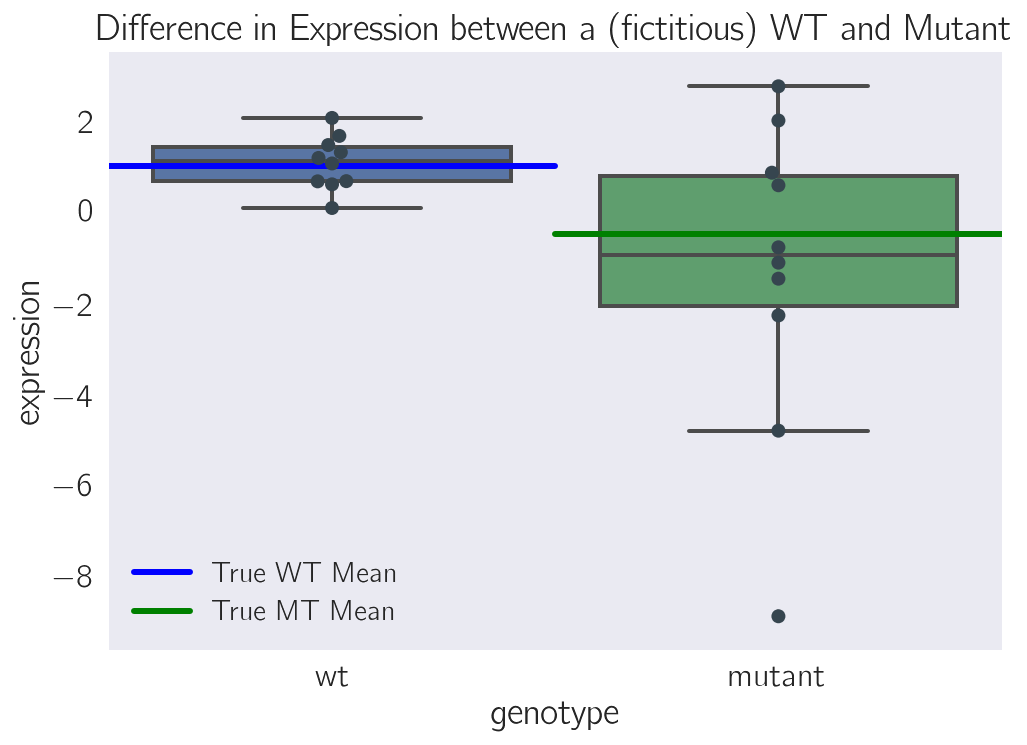

In [8]:
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')
plt.gca().axhline(1, xmin=0, xmax=0.5, color='blue', label='True WT Mean', lw=3)
plt.gca().axhline(-0.5, xmin=0.5, xmax=1, color='green', label='True MT Mean', lw=3)
plt.legend()
plt.title('Difference in Expression between a (fictitious) WT and Mutant')

In [16]:
def non_parametric_bootstrap(x, f, nsim=1000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))
        
        statistic[i] = f(X, **kwargs)
    
    return statistic

def non_parametric_bootstrap_statistic(x, y, f, nsim=1000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))

        # simulate y
        indices = np.random.randint(0, len(y), len(y))
        Y = y[indices]
        Y += np.random.normal(0, 0.05, len(x))
        
        statistic[i] = f(X, Y, **kwargs)[1]
    
    return statistic


In [17]:
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values

scipy.stats.mannwhitneyu(wt, mt)

MannwhitneyuResult(statistic=24.0, pvalue=0.026951278584693587)

In [18]:
meanx = non_parametric_bootstrap(x, np.mean)
meany = non_parametric_bootstrap(y, np.mean)
pvals = non_parametric_bootstrap_statistic(wt, mt, scipy.stats.mannwhitneyu)

p-value: 0.0


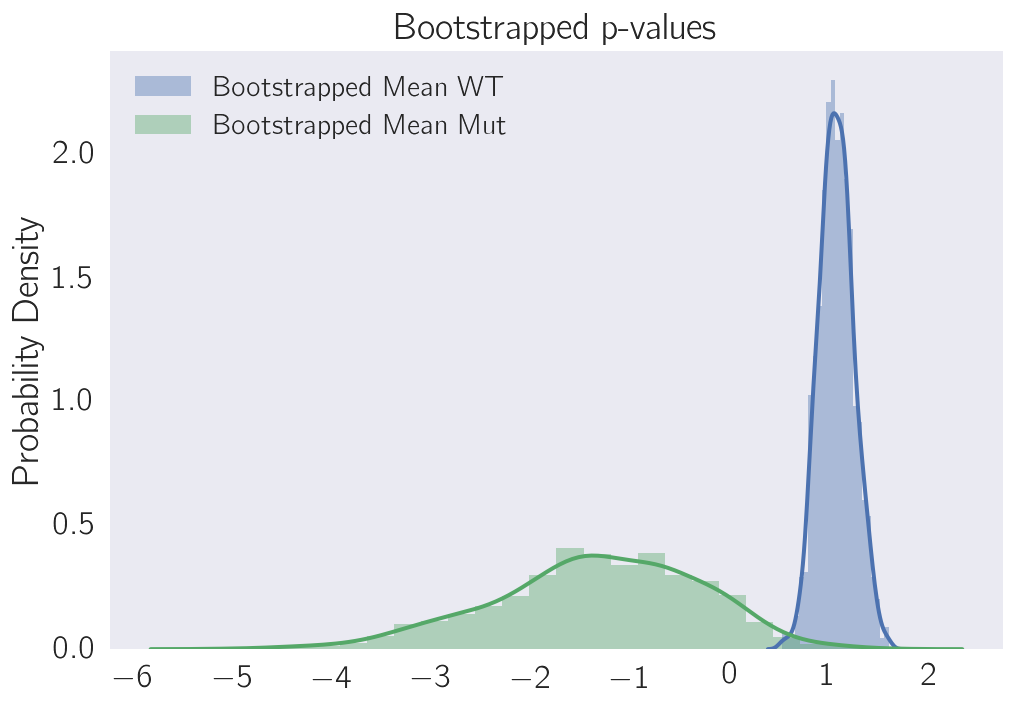

In [19]:
sns.distplot(meanx, label='Bootstrapped Mean WT')
sns.distplot(meany, label='Bootstrapped Mean Mut')
# plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
# plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
# plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped p-values')
plt.legend()

fraction = len(meanx[meanx < meany.mean()])/len(meanx)
print('p-value: {0}'.format(fraction))

Fraction of the time the p-value was less than 0.05: 0.646


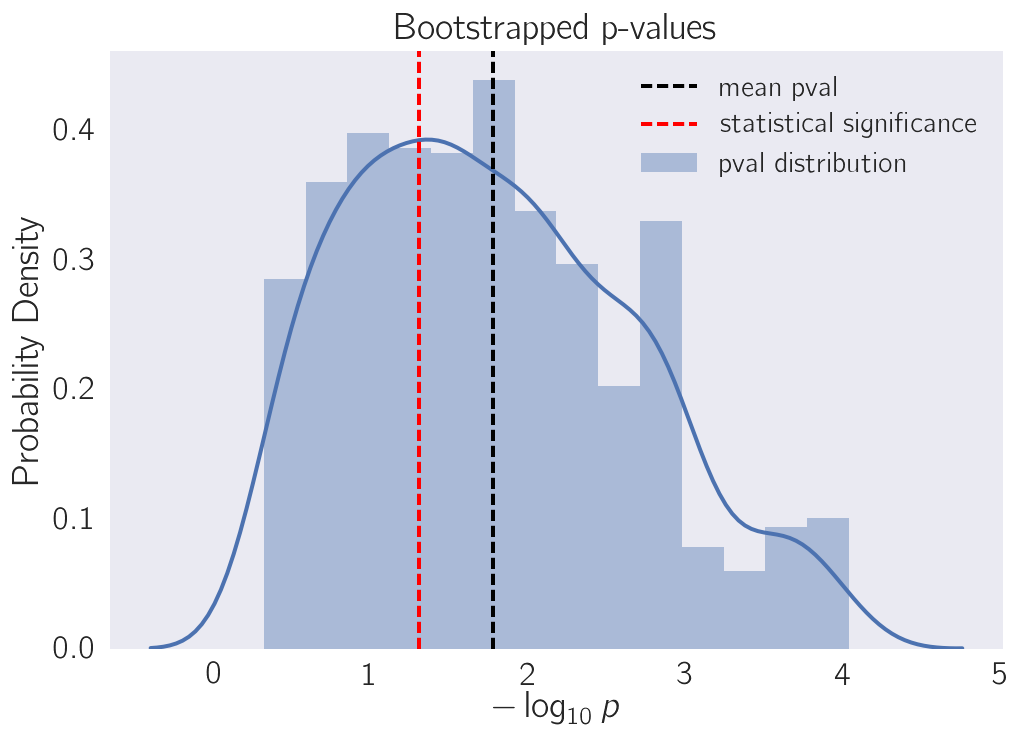

In [49]:
logp = -np.log(pvals)/np.log(10)

sns.distplot(logp, label='pval distribution')
plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped p-values')
plt.legend()

fraction = len(pvals[pvals < 0.05])/len(pvals)
print('Fraction of the time the p-value was less than 0.05: {0}'.format(fraction))

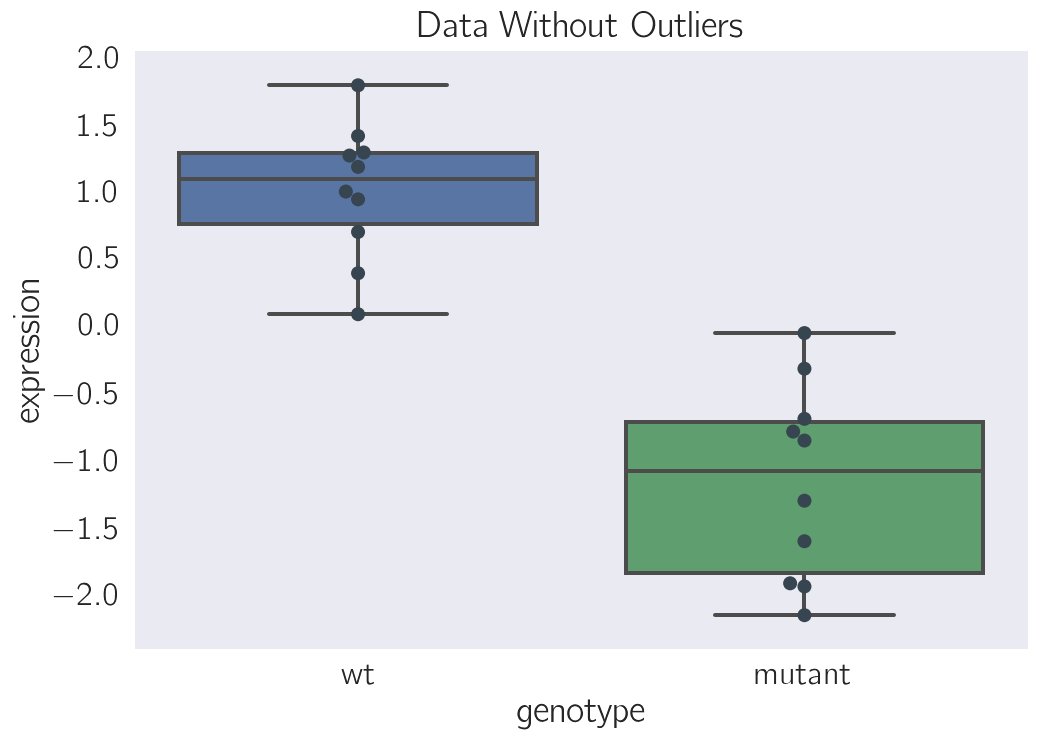

In [35]:
x = np.random.normal(1, .5, 10)
y= np.random.standard_t(2.7, 10) - 1

data = np.vstack([x, y]).transpose()
df = pd.DataFrame(data, columns=['wt', 'mutant'])

# tidy:
tidy = pd.melt(df, var_name = 'genotype', value_name='expression')
sns.boxplot(x='genotype', y='expression', data=tidy)
sns.swarmplot(x='genotype', y='expression', data=tidy, size=7, color='#36454F')

plt.title('Data Without Outliers')

Fraction of the time the p-value was less than 0.05: 1.0


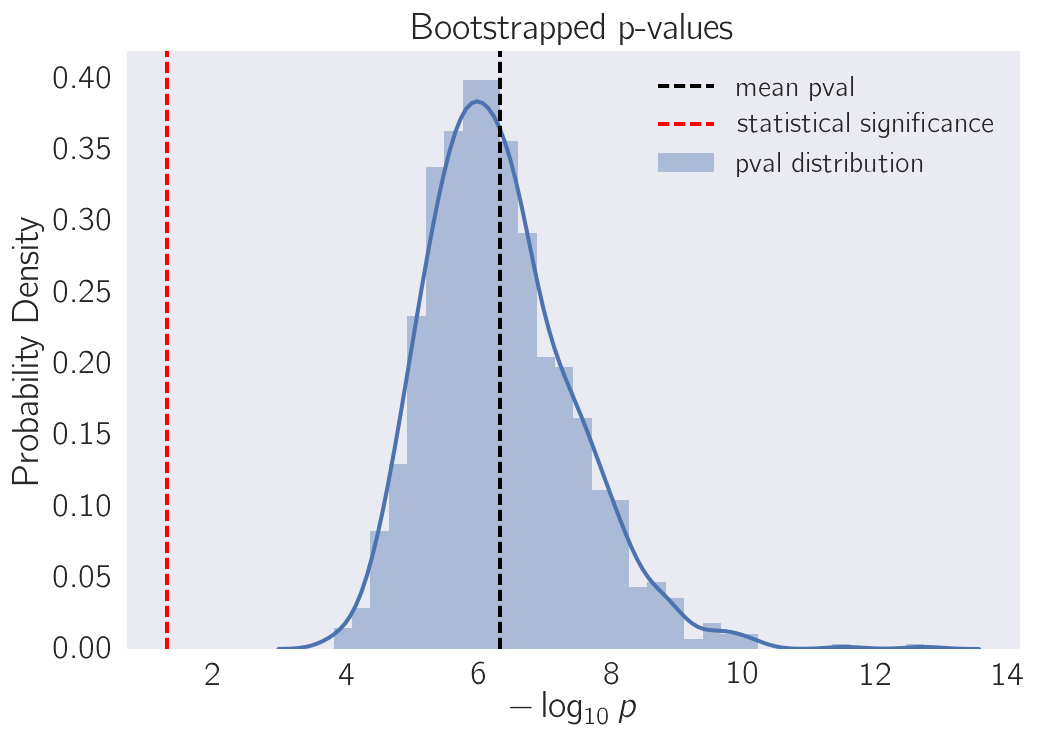

In [36]:
wt = tidy[tidy.genotype == 'wt'].expression.values
mt = tidy[tidy.genotype == 'mutant'].expression.values

pvals = non_parametric_bootstrap(wt, mt, scipy.stats.ttest_ind, equal_var=False)

logp = -np.log(pvals)/np.log(10)

sns.distplot(logp, label='pval distribution')
plt.gca().axvline(logp.mean(), ls='--', color='k', label='mean pval')
plt.gca().axvline(-np.log(0.05)/np.log(10), ls='--', color='r', label='statistical significance')
plt.xlabel('$-\log_{10}{p}$')
plt.ylabel('Probability Density')
plt.title('Bootstrapped p-values')
plt.legend()


fraction = len(pvals[pvals < 0.05])/len(pvals)
print('Fraction of the time the p-value was less than 0.05: {0}'.format(fraction))